Use conda environment `conda_envs/hic_nikita.yml` to run this notebook.

In [1]:
import sys
sys.path.append('scripts')

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import os
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.api.types import CategoricalDtype

# Some additional for plots
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

import cooler # Hi-C data processing
import networkx as nx # Network analysis
import pingouin as pg # Statistics

# Some utils for notebook
from tqdm import tqdm
from IPython.display import display

# Custom
from my_loops_module import *
from my_network_utils import *

/home/nvaulin/tools/mambaforge/envs/hic-env/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [5]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Input data:

- `data/polycomb_dots_hand_coords_update_June25.tsv` - Polycomb dot coordinates identified in this paper
- `/tank/projects/polycomb/data/heffel/cools/*.cool` - snm3C-seq data from *Heffel et al.*
- `/tank/projects/polycomb/results/2024.04.23/metadata.heffel.all_ctx.tsv.gz` - snm3C-seq metadata from *Heffel et al.*
- `data/polycomb_dots_intensities_pad10kb_Heffel.csv` - Polycomb dot intensities identified in this paper (in notebook *code/Loops_vs_Expression/8_Get_sc_loops_intensities_Heffel.ipynb*)

In [ ]:
data_dir = '../../data/'

In [19]:
coolers = os.listdir('/tank/projects/polycomb/data/heffel/cools')
m3C_meta = pd.read_csv('/tank/projects/polycomb/results/2024.04.23/metadata.heffel.all_ctx.tsv.gz', sep='\t', index_col=0)
m3C_meta['cell_type'] = m3C_meta['age_groups'] + ' ' + m3C_meta['L1 annotation'].map({'Exc': 'EN', 'Inh': 'IN', 'Non-Neuron': 'NN', 'RG': 'RG'})
m3L1 = m3C_meta['L1 annotation']
mask = m3L1 == 'RG'
m3C_meta.loc[mask , 'cell_type'] = m3C_meta['age_groups'] + ' ' + m3C_meta.loc[mask, 'L3 annotation']#.str.replace('_', ' ')

In [23]:
cells_contact_sums = m3C_meta.cooler_fpath.apply(lambda x: cooler.Cooler(x).info['sum'])
cells_contact_sums.index.name = 'cell'
cells_contact_sums = cells_contact_sums.to_frame().rename({'cooler_fpath':'contacts_sum'}, axis=1)
# cells_contact_sums.to_csv('/tank/projects/nvaulin_hic_sch/tian_polycomb_analysis/Heffel_cells_contacts_sums.csv', header=True)
# cells_contact_sums = pd.read_csv('/tank/projects/nvaulin_hic_sch/tian_polycomb_analysis/Heffel_cells_contacts_sums.csv', index_col=0)

In [63]:
pcg_sc_loops = pd.read_csv(data + 'polycomb_dots_intensities_pad10kb_Heffel.csv', header=[0,1])

cols = [ (c1, c2) for c1, c2 in pcg_sc_loops.columns.tolist()]
cols[0] = 'cell'
cols = list(map(lambda x: x if x == 'cell' else tuple([eval(x[0]), eval(x[1])]), cols))

pcg_sc_loops.columns = cols
pcg_sc_loops = pcg_sc_loops.dropna(subset=['cell']).set_index('cell')

In [22]:
from pandas.api.types import CategoricalDtype
regions_groups = {
    'Basal Nuclei': ['AMY', 'CMN', 'CaB', 'GPe', 'BNST', 'NAC', 'Pu'],
    'Basal Forebrain': ['SI', 'SEP'],
    'Cerebral cortex': ['MTG', 'LEC', 'A24', 'A46', 'FI', 'M1C', 'V1C', 'Pir']
}
 
age_type = CategoricalDtype(categories=['2T' , '3T', 'infant', 'adult'], ordered=True)
cats = [cs[1] + ' ' + cs[0] for cs in list(itertools.product(['EN',  'IN', 'NN',  'RG-1', 'RG-2'], ['2T' , '3T', 'infant', 'adult']))]
cats = [c for c in cats if c in m3C_meta['cell_type'].unique()]
ct_type = CategoricalDtype(categories=cats, ordered=True)
chr_type = CategoricalDtype(categories=chroms, ordered=True)


ct_palette = {"EN": "#3924B1",
              "IN": "#C1118C",
              "NN": "#ffc875"}

def get_chr(loop_coords):
    chr1 = loop_coords[0][0]
    chr2 = loop_coords[1][0]
    return chr1 if chr1 == chr2 else 'trans'

chroms_colors = {chroms[i] : plt.get_cmap('tab20b')((i+1) / len(chroms)) for i in range(len(chroms[:-1])) }
chroms_colors['trans'] = (0,0,0)

In [64]:
pcg_sc_loops.index = pcg_sc_loops.index.to_series().apply(lambda x: x.removesuffix('.cool').removesuffix('.10kb'))

cells = pcg_sc_loops.index.tolist()
pcg_sc_loops = pcg_sc_loops.T.reset_index()

In [65]:
pcg_sc_loops['loop'] =  pcg_sc_loops['index'].apply(lambda x: Loop(x))
pcg_sc_loops = pcg_sc_loops[['loop'] + cells]
pcg_sc_loops = pcg_sc_loops.sort_values(by='loop')

metacols = ['cell_type', 'L1 annotation', 'L2 annotation', 'L3 annotation', 'Sample','age_groups']
pcg_sc_loops_meta = pcg_sc_loops.sort_values(by=['loop'])\
                                .set_index('loop')\
                                .T\
                                .join(m3C_meta[metacols])\
                                .astype({"age_groups": age_type, "cell_type": ct_type})\
                                .set_index(metacols, append=True)\
                                .sort_index(level=metacols)

pcg_sc_loops_meta = (pcg_sc_loops_meta != 0).astype(int)
pcg_sc_loops_meta_norm = pcg_sc_loops_meta.div(cells_contact_sums.contacts_sum, axis=0)

In [66]:
cell_counts = pcg_sc_loops_meta.index.get_level_values('cell_type').value_counts()
cell_counts = cell_counts[cell_counts>500]

pcg_sc_loops_meta_norm = pcg_sc_loops_meta_norm.loc[[(ct in cell_counts) and 'NN' not in ct for ct in pcg_sc_loops_meta_norm.index.get_level_values('cell_type')]]

In [67]:
pcg_sc_loops_meta_norm = pcg_sc_loops_meta_norm.reset_index('cell_type')
pcg_sc_loops_meta_norm['cell_type'] = pcg_sc_loops_meta_norm['cell_type'].cat.remove_unused_categories()
pcg_sc_loops_meta_norm = pcg_sc_loops_meta_norm.set_index('cell_type', append=True)

In [68]:
def group_and_normalize(df, col, div_by_total=False, add_total=True, return_cell_counts=False):
    values = df.groupby(col).sum()
    cells_counts = m3C_meta[col].value_counts().to_frame().loc[values.index]
    values_norm = values.div(cells_counts['count'], axis=0)
    total = values_norm.sum(axis=0, skipna=True)
    if div_by_total:
        values_norm = values_norm.div(total, axis=1)
    if add_total:
        values_norm.loc['Total'] = total
    if return_cell_counts:
        return values_norm, cells_counts
        
    return values_norm

In [69]:
pcg_sc_loops_meta_norm_grouped, cells_counts = group_and_normalize(pcg_sc_loops_meta_norm, 'cell_type', div_by_total=True, add_total=False, return_cell_counts=True)
pcg_sc_loops_meta_norm_grouped = pcg_sc_loops_meta_norm_grouped.fillna(0)

In [70]:
# # maj_type_ordered = [
# #     'DG', 'CA3', 'CA1', 'HIP-Misc1', 'HIP-Misc2', 'L4-IT', 'L5-IT', 'L5-ET', 'Amy-Exc', 
# #     'L2/3-IT', 'L6-IT', 'L6-IT-Car3', 'L5/6-NP', 'L6b', 'L6-CT', 'Foxp2', 'MSN-D1', 
# #     'MSN-D2', 'Chd7', 'Vip', 'Sncg', 'Lamp5-Lhx6', 'Lamp5', 'Sst', 'Pvalb', 'Pvalb-ChC', 
# #     'SubCtx-Cplx', 'THM-Inh', 'THM-Exc', 'PN', 'PKJ', 'CB', 'VLMC', 'OPC', 'MGC', 'PC', 'EC',
# #     'ODC', 'ASC'
# # ]

# maj_type_ordered = pcg_sc_loops_meta_norm_grouped.index.to_list()

# to_save_whole = pcg_sc_loops_meta_norm_grouped.copy()
# to_save_whole.index = to_save_whole.index.astype(CategoricalDtype(maj_type_ordered, ordered=True))
# to_save_whole = to_save_whole.sort_index()
# to_save_whole = to_save_whole.fillna(0)

# to_save_whole.to_pickle(data+'pcg_loops_groupedL2anno_norm_whole_Heffel.pkl')

In [71]:
df_for_heatmap = pcg_sc_loops_meta_norm_grouped

In [72]:
# chroms = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14',
#        'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chrX'] + ['trans']
# chroms_colors = {chroms[i] : plt.get_cmap('tab20b')((i+1) / len(chroms)) for i in range(len(chroms[:-1])) }
# chroms_colors['trans'] = (0,0,0)

<Axes: ylabel='cell_type'>

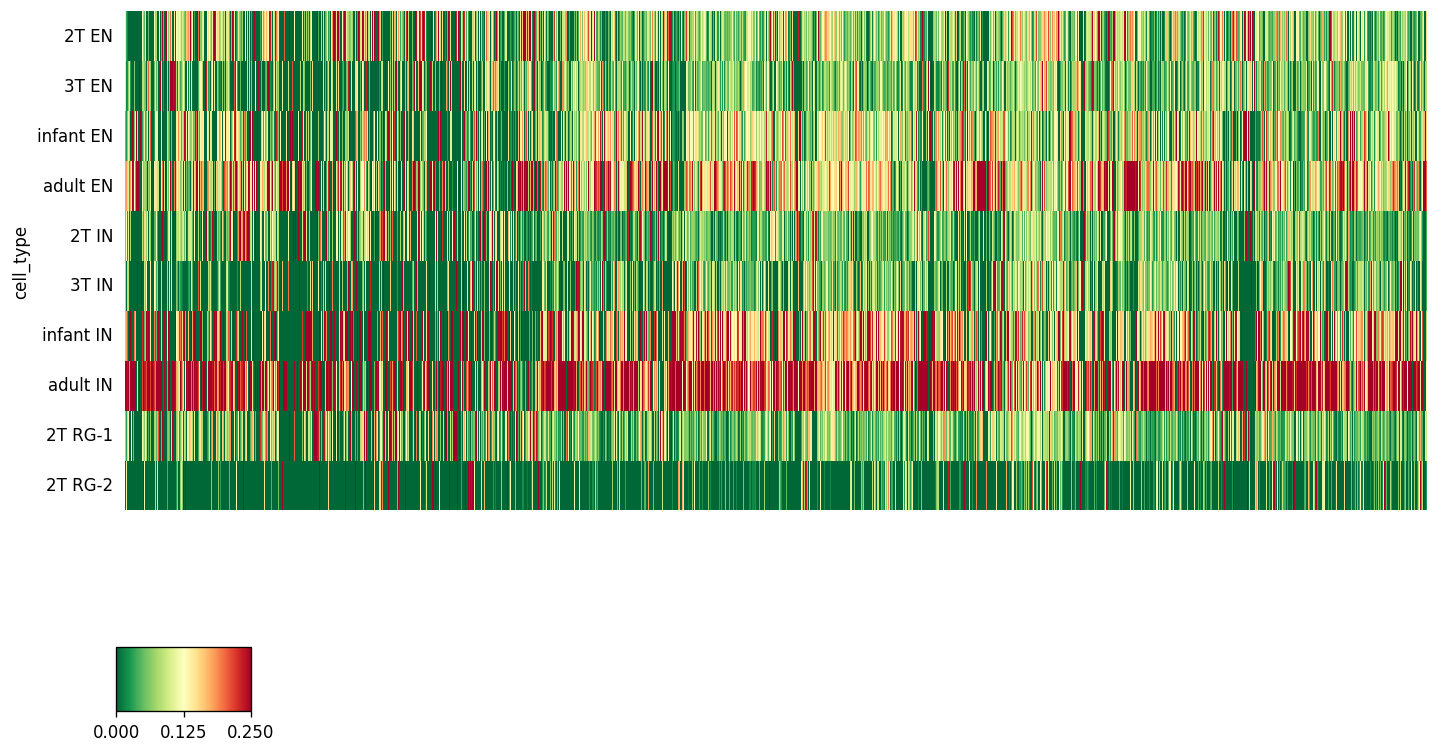

In [73]:
plot_heatmap_for_clusters(pcg_sc_loops_meta_norm_grouped, mins_maxs=(0, 0.25), totals=False, add_chroms=False)

In [74]:
from sklearn.cluster import KMeans

X = pcg_sc_loops_meta_norm_grouped.iloc[:-1].T
n_clusters = 10

In [75]:
preds_raw = KMeans(n_clusters=n_clusters, random_state=1).fit_predict(X)
clusters_raw = list(set(preds_raw))

clusters_main_cts = dict()
# clusters_main_cts = {
#     'Exc-DL': [4,],
#     'Exc-UL': [6,],
#     'Inh-MGE': [7,],
#     'Inh': [2, ],
#     'UL-MGE': [3],
#     'UL-CGE': [8],
#     'Common/MGE': [0],
#     'Common': [1, 5],
# }

clusters_main_cts_rev = {v:k for k, vs in clusters_main_cts.items() for v in vs}
preds = [clusters_main_cts_rev[p] if p in clusters_main_cts_rev else p for p in preds_raw]
clusters = list(clusters_main_cts.keys()) + list(clusters_raw - clusters_main_cts_rev.keys())

preds = pd.DataFrame({'preds': preds, 'preds_raw': preds_raw, 'loop':pcg_sc_loops_meta_norm_grouped.T.index})

preds['preds'] = preds['preds'].astype(CategoricalDtype(clusters, ordered=True))
preds['preds_raw'] = preds['preds_raw'].astype(CategoricalDtype(clusters_raw, ordered=True))
preds_ordered = preds.sort_values(by=['preds', 'loop'])# ['preds', 'preds_raw',  'loop']
pred_order_loops = preds_ordered.loop.to_list()

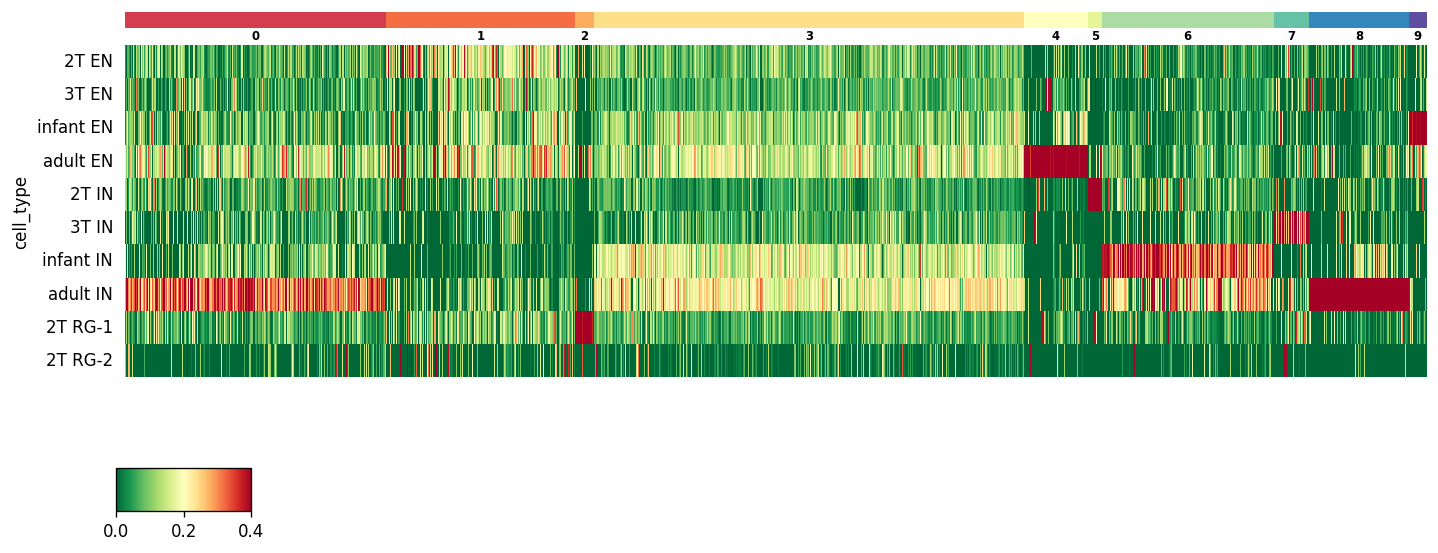

In [76]:
df_for_heatmap = pcg_sc_loops_meta_norm_grouped[pred_order_loops]

ax = plot_heatmap_for_clusters(df_for_heatmap, mins_maxs=(0, 0.4), totals=False, add_chroms=False, rw=0.4)

## Raw clusters
clusters_colors = {clusters_raw[i] : plt.get_cmap('Spectral')((i+1) / len(clusters_raw)) for i in range(len(clusters_raw)) }
for i, color in enumerate(preds_ordered['preds_raw'].cat.rename_categories(clusters_colors).values):
    rect = plt.Rectangle(xy=(i, -1), height=.5, width=1, color=color, lw=0, transform=ax.transData, clip_on=False)
    ax.add_patch(rect)

# ## Recoded clusters
# clusters_colors = {clusters[i] : plt.get_cmap('tab10')((i+1) / len(clusters)) for i in range(len(clusters)) }
# for i, color in enumerate(preds_ordered['preds'].cat.rename_categories(clusters_colors).values):
#     rect = plt.Rectangle(xy=(i, -.5), height=.5, width=1, color=color, lw=0, transform=ax.transData, clip_on=False)
#     ax.add_patch(rect)

pad = 0
sizes = preds_ordered['preds'].value_counts(sort=False).to_frame()
counts = [0] + sizes['count'].to_list()
for i, cluster in enumerate(preds_ordered['preds'].values):
    if i in [sum(counts[:i])+counts[i]//2 for i in range(0, len(counts))][1:]: 
        ax.annotate(cluster, (i, -.25 - pad), transform=ax.transData, annotation_clip=False, 
                    color='k', weight='bold', fontsize=7, ha='center', va='center')

In [77]:
# polycomb_loops_clusters.astype({'gene1': 'str', 'gene2':'str'}).to_csv(data+'Polycomb_Loops_Clusters_from_big_heatmap_Heffel.csv', index=False)
pcg_sc_loops_meta_norm_grouped.to_pickle(data+'pcg_loops_grouped_norm_Heffel.pkl')

In [79]:
ct_palette = {"2T": "#f3ffba",
              "3T": "#b2dabf",
              "infant": "#6ec2b3",
              "adult": "#247a9b"}

# major_types_to_celltype = m3C_meta[['L2 annotation', 'L1 annotation']].drop_duplicates().set_index('L2 annotation')['L1 annotation'].to_dict()

In [80]:
from sklearn.decomposition import PCA
ages_cts = pcg_sc_loops_meta_norm_grouped.index.to_series()
ages = ages_cts.str.split().str[0]
ages = pcg_sc_loops_meta_norm_grouped.index.to_series().str.split().str[0]
dots_colors = ages.map(ct_palette).values

In [83]:
dots_colors[ list(ages.index).index('2T RG-1') ] = 'grey'
dots_colors[ list(ages.index).index('2T RG-2') ] = 'grey'

In [84]:
pca = PCA(n_components=4)
pca_result = pca.fit_transform(pcg_sc_loops_meta_norm_grouped)
explained_variance = pca.explained_variance_ratio_ * 100  # Convert to percentage

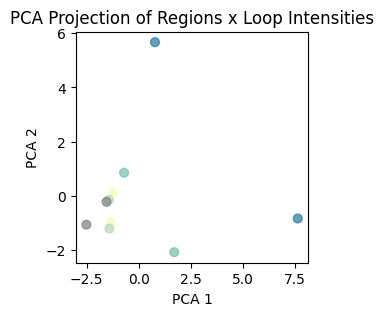

In [85]:
plt.figure(figsize=(3, 3))
plt.scatter(pca_result[:, 0], pca_result[:, 1], 
            c=dots_colors,
            s=40, alpha=0.7)
plt.title('PCA Projection of Regions x Loop Intensities')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [86]:
from adjustText import adjust_text

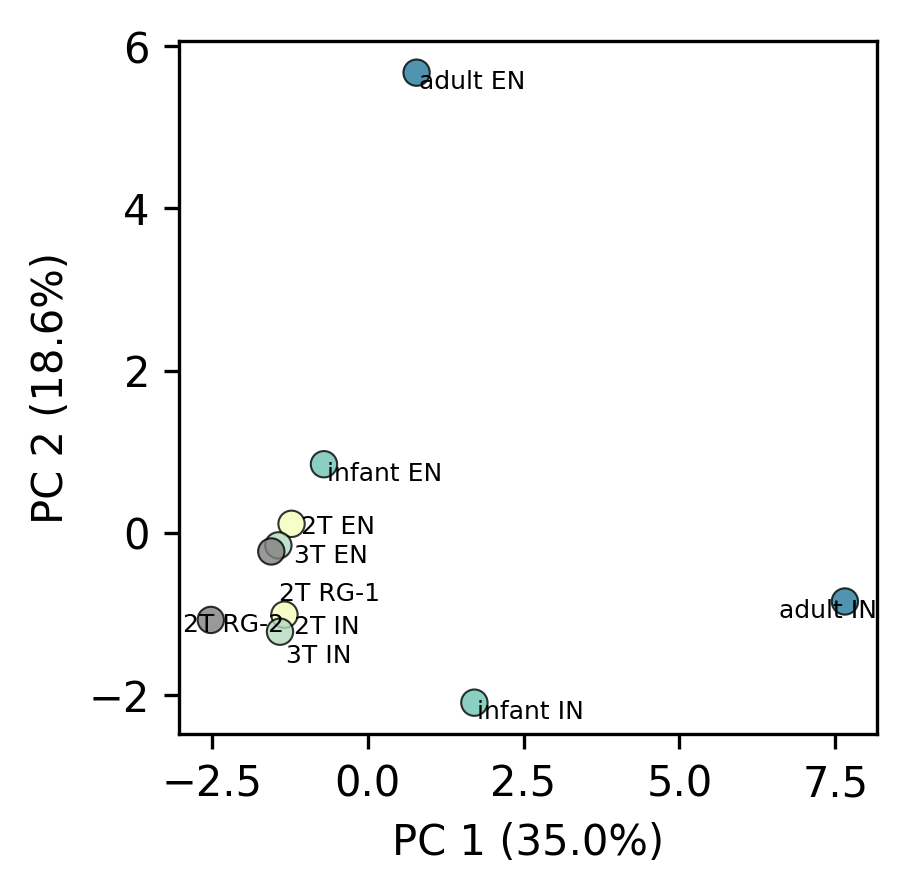

In [87]:
plt.figure(figsize=(3, 3), dpi=300)
plt.scatter(pca_result[:, 0], pca_result[:, 1], 
            c=dots_colors, edgecolor='k', linewidth=0.5,
            s=40, alpha=0.8)

texts = []
for i in range(len(pca_result)):
    x, y, t = pca_result[i, 0], pca_result[i, 1], ages_cts[i]
    # if x <-0.4 and y<0.1:
    #     continue
    t = plt.text(x, y-.3, t, fontsize=6)
    texts.append(t)
adjust_text(texts)

# Add explained variance to axis labels
plt.xlabel(f'PC 1 ({explained_variance[0]:.1f}%)')
plt.ylabel(f'PC 2 ({explained_variance[1]:.1f}%)')


# plt.savefig('imgs/Fig3C_PCA_Heffel.pdf', bbox_inches='tight')
plt.show()

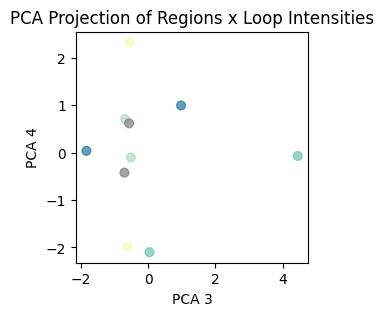

In [88]:
plt.figure(figsize=(3, 3))
plt.scatter(pca_result[:, 2], pca_result[:, 3], 
            c=dots_colors,
            s=40, alpha=0.7)
plt.title('PCA Projection of Regions x Loop Intensities')
plt.xlabel('PCA 3')
plt.ylabel('PCA 4')
plt.show()

In [89]:
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose so features are rows, PCs are columns
    columns=[f'PC{i + 1}' for i in range(pca.n_components_)],
    index=pcg_sc_loops_meta_norm_grouped.columns  # Feature names
)

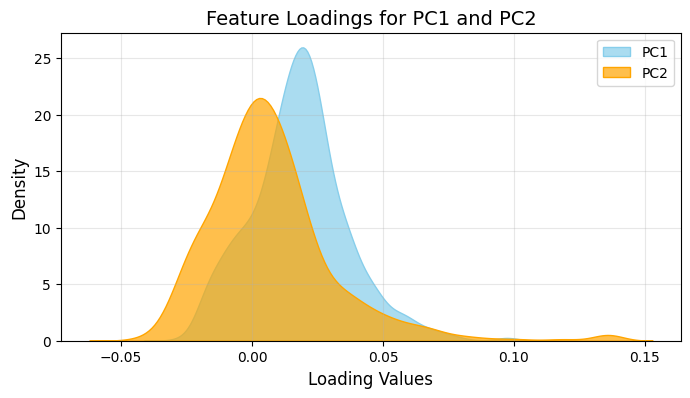

In [90]:
plt.figure(figsize=(8, 4))
sns.kdeplot(loadings['PC1'], label='PC1', fill=True, color='skyblue', alpha=0.7)
sns.kdeplot(loadings['PC2'], label='PC2', fill=True, color='orange', alpha=0.7)

# Add labels, title, and legend
plt.title('Feature Loadings for PC1 and PC2', fontsize=14)
plt.xlabel('Loading Values', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)


# plt.savefig('imgs/FigS3C_PCA_Loadings_Heffel.pdf', bbox_inches='tight')
plt.show()

In [91]:
loadings.to_csv(data + 'Polycomb_Loops_PCA_Loadings_Heffel.csv')
loadings

,PC1,PC2,PC3,PC4
"(('chr1', 18630000, 18640000), ('chr1', 24930000, 24940000))",0.022435,-0.007342,0.002345,-0.006491
"(('chr1', 18630000, 18640000), ('chr1', 44410000, 44420000))",0.026197,0.004029,0.010153,0.025710
"(('chr1', 18630000, 18640000), ('chr1', 46480000, 46490000))",0.008672,-0.005377,0.019888,-0.000591
"(('chr1', 18630000, 18640000), ('chr1', 47180000, 47250000))",0.023174,0.001683,0.016284,0.007751
"(('chr1', 18630000, 18640000), ('chr1', 47430000, 47440000))",0.032741,0.002048,-0.033197,0.008275
...,...,...,...,...
"(('chr20', 21085000, 21115000), ('chr20', 38710000, 38730000))",0.008003,0.079232,0.012474,-0.007817
"(('chr20', 21380000, 21410000), ('chr20', 38710000, 38730000))",-0.014630,0.031106,-0.002316,0.007069
"(('chr20', 21500000, 21525000), ('chr20', 38710000, 38730000))",0.006739,0.115998,0.031088,0.029154
"(('chr20', 22560000, 22590000), ('chr20', 38710000, 38730000))",-0.000853,0.076102,0.015664,-0.010445
